<a href="https://colab.research.google.com/github/annykay/NoiseInDataImpact/blob/main/MLbasedImputation/MissingImportantFeaturesAndImputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor


In [ ]:
def plot_results(result, datasetname, inputation, test = True):
    plt.figure(figsize=(10,8))
    plt.plot([i/20 for i in range(20)], np.array(result)[:,0], label = 'DTC')
    plt.plot([i/20 for i in range(20)], np.array(result)[:,1], label = 'RFC')
    plt.plot([i/20 for i in range(20)], np.array(result)[:,2], label = 'KNN')
    plt.plot([i/20 for i in range(20)], np.array(result)[:,3], label = 'XGB')
    plt.plot([i/20 for i in range(20)], np.array(result)[:,4], label = 'LRC')
    if test:
        plt.title('{} DataSet(Test). Important Features Corruption. {} Imputation'.format(datasetname, inputation))
    else:
        plt.title('{} DataSet(Train). Important Features Corruption. {} Imputation'.format(datasetname, inputation))
    plt.xlabel('Drop Level')
    plt.ylabel('F1 score')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
def plot_all_results(result_lr, result_dt, result_knn, result_extra, dataset, test = True):
    plt.figure(figsize=(10,8))
    imps = ['LR', 'RFR', 'KNR', 'ETR']
    styles = ['-', '--', ':', '-.']
    for result, imp, st in zip([result_lr, result_dt, result_knn, result_extra], imps,styles):
        plt.plot([i/20 for i in range(20)], np.array(result)[:,0], color = 'b', 
                 linestyle = st, label = 'DTC, {} Imputation'.format(imp))
        plt.plot([i/20 for i in range(20)], np.array(result)[:,1], color = 'y', 
                 linestyle = st, label = 'RFC, {} Imputation'.format(imp))
        plt.plot([i/20 for i in range(20)], np.array(result)[:,2], color = 'g', 
                 linestyle = st, label = 'KNN, {} Imputation'.format(imp))
        plt.plot([i/20 for i in range(20)], np.array(result)[:,3], color = 'r',
                 linestyle = st, label = 'XGB, {} Imputation'.format(imp))
        plt.plot([i/20 for i in range(20)], np.array(result)[:,4], color = 'm', 
                 linestyle = st, label = 'LRC, {} Imputation'.format(imp))
    if test:
        plt.title('{} DataSet(Test). Target Corruption'.format(dataset))
    else:
        plt.title('{} DataSet(Train). Target Corruption'.format(dataset))
    plt.xlabel('Drop Level')
    plt.ylabel('F1 score')
    plt.grid()
    plt.legend()

In [ ]:

X = pd.read_csv('Pulsars_features.csv', index_col= 0)
y = pd.read_csv('Pulsars_labels.csv', index_col = 0)


tree = DecisionTreeClassifier(random_state=0, max_depth = 2)
forst = RandomForestClassifier(random_state=0, n_jobs = -1, max_depth= 7,  n_estimators = 10, max_features = 6)
ada = AdaBoostClassifier(learning_rate= 0.6, n_estimators=50)
knn = KNeighborsClassifier(n_neighbors = 9, n_jobs=-1)
xgvClf = xgb.XGBClassifier(random_state=0, learning_rate=0.3, max_depth = 3, n_estimators=70, )
logReg = LogisticRegression(random_state=0, C=12, n_jobs = -1)


clfs = [tree,
        forst, 
        knn,
        xgvClf,
        logReg
       ]

def Scores(clfs, X_train, X_test, y_train, y_test):
    
    train_scores = []
    test_scores = []
    importances = []
    for reg in clfs:
        reg.fit(X_train, y_train)
        y_train_pred = reg.predict(X_train)
        y_test_pred = reg.predict(X_test)
        train_score = round(f1_score(y_train, y_train_pred, average='micro'), 2)
        test_score = round(f1_score(y_test, y_test_pred, average='micro'), 2)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    return train_scores, test_scores

def corupt_important_features(n, X, y, important, clfs, est):
    Train_Scores = []
    Test_Scores = []
    features = [i for i in range(X.shape[1])]
    not_important = [i  for i in features if i not in important] 
    print(not_important)
    for i in range(n):
        level = i/n
        print(level)
        D = X.copy()
        imp = IterativeImputer(estimator = est, max_iter=3, random_state=0)
        mask = np.random.binomial(1, level, size=(D.shape[0],D.shape[1]))
        mask[:, not_important] = 0
        mask = mask.astype(bool)
        D[mask] = np.nan
        X_train, X_test, y_train, y_test = train_test_split(
             D, y, test_size=0.7, random_state=0)
    
        imp.fit(X_train)
        X_train = imp.transform(X_train)
        X_test = imp.transform(X_test)
    
        scores = Scores(clfs, X_train, X_test, y_train, y_test)
        print(scores)
    
        Train_Scores.append(scores[0])
        Test_Scores.append(scores[1])
        
    return (Train_Scores, Test_Scores)

# Indexes of Important Features were Obtained from my Teammates' analysis 
important_pulsar = [2,3]
important_stellar = [-3]
important_rice = [1,3,4,-1]
important_bank = [1,3,4,-1]

In [ ]:
pulsar_train_imp, pulsar_test_imp = corupt_important_features(20, X, y,  important_pulsar, clfs, est = None)
pd.DataFrame(pulsar_train_imp).to_csv('PulsarF1TrainScoresImp.csv', index = False)
pd.DataFrame(pulsar_test_imp).to_csv('PulsarF1TestScoresImp.csv', index = False)

In [ ]:
pulsar_train_imp_forest, pulsar_test_imp_forest = corupt_important_features(20, X, y, important_pulsar, clfs, est = DecisionTreeRegressor())
pd.DataFrame(pulsar_train_imp_forest).to_csv('PulsarF1TrainScoresDTImp.csv', index = False)
pd.DataFrame(pulsar_test_imp_forest).to_csv('PulsarF1TestScoresDTImp.csv', index = False)

In [ ]:
pulsar_train_imp_knn, pulsar_test_imp_knn = corupt_important_features(20, X, y, important_pulsar, clfs, est = KNeighborsRegressor())
pd.DataFrame(pulsar_train_imp_knn).to_csv('PulsarF1TrainScoresImpKNN.csv', index = False)
pd.DataFrame(pulsar_test_imp_knn).to_csv('PulsarF1TestScoresImpKNN.csv', index = False)

In [ ]:
pulsar_train_imp_extra, pulsar_test_imp_extra = corupt_important_features(20, X, y, important_pulsar, clfs, est = ExtraTreesRegressor())
pd.DataFrame(pulsar_train_imp_extra).to_csv('PulsarF1TrainScoresImpETRcsv', index = False)
pd.DataFrame(pulsar_test_imp_extra).to_csv('PulsarF1TestScoresImpETR.csv', index = False)

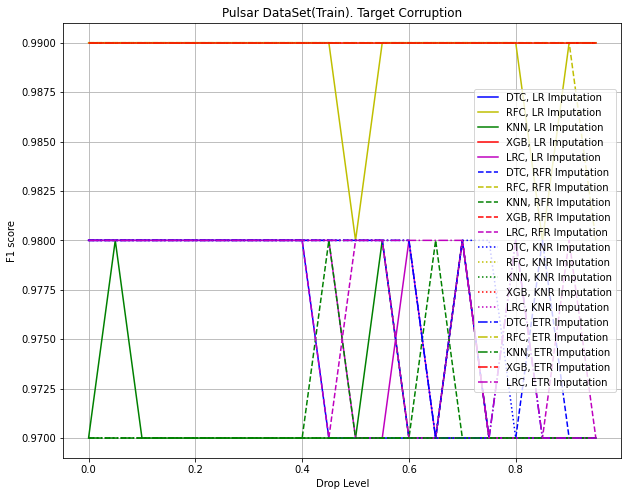

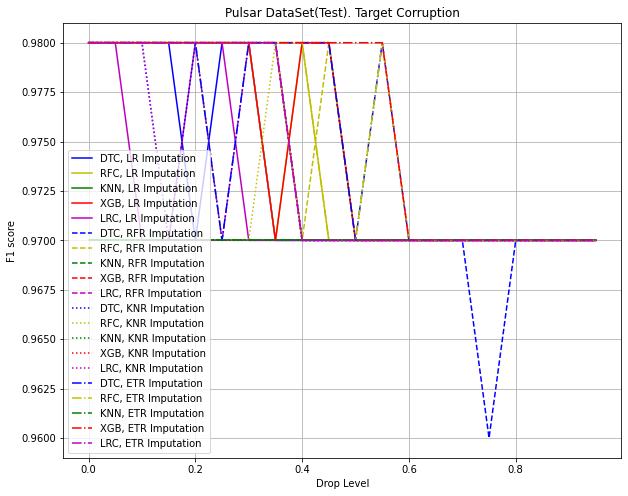

In [ ]:
plot_all_results(pulsar_train_imp, pulsar_train_imp_forest, pulsar_train_imp_knn, pulsar_train_imp_extra, 'Pulsar', test = False)
plot_all_results(pulsar_test_imp, pulsar_test_imp_forest, pulsar_test_imp_knn, pulsar_test_imp_extra, 'Pulsar', test = True)
